C:\Users\faiza\AppData\Local\Temp\ipykernel_33408\1780216647.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('core/checkpoints_improved/fixed_be

Models loaded successfully on cuda
Loading 13 images from data/
Loaded 13 views with shape torch.Size([13, 3, 256, 256])
Running inference...

=== MODEL OUTPUT STATISTICS ===
Encoder features: min=-0.9983, max=8.6931, mean=0.1148
Decoder raw_features: min=-39.8873, max=45.3508, mean=3.6103
Decoder gen_volumes: min=-39.8873, max=7.2441, mean=-6.2740
Merger output (logits): min=-32.8483, max=5.5726, mean=-10.9005
Merged sigmoid: min=0.0000, max=0.9962, mean=0.0351
Refined logits: min=0.0000, max=1.0000, mean=0.0216
Refined sigmoid: min=0.5000, max=0.7311, mean=0.5050

=== RESULTS ===
Voxel grid shape: torch.Size([1, 32, 32, 32])
Nonzero predicted voxels: 754.0
Occupancy ratio: 0.0230
Saved voxel grid to 'output_voxels.npy'


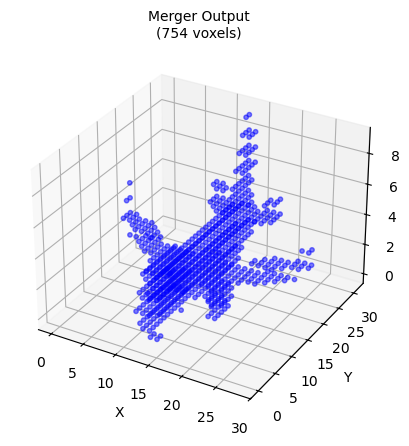

Saved visualization to 'inference_vis.png'


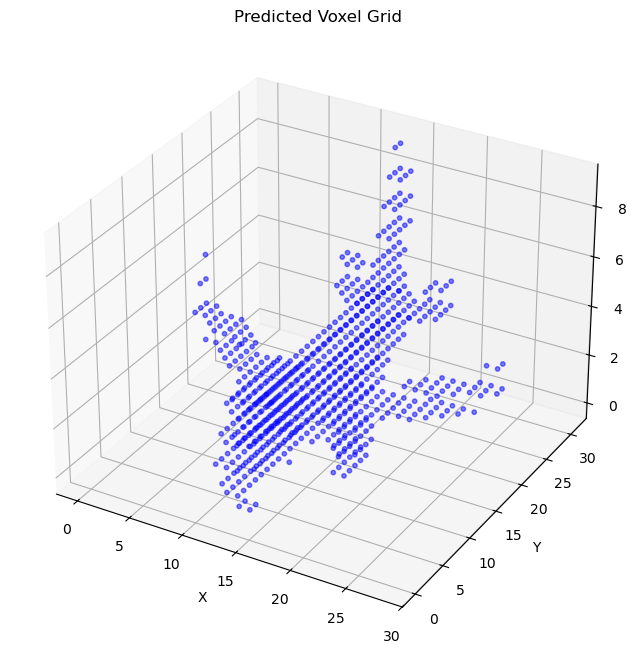

Saved OBJ mesh to 'output.obj'


In [9]:
import torch
import os
import numpy as np
from models.encoder import Encoder
from models.decoder import Decoder
from models.merger import Merger
from models.refiner import Refiner
from utils.visualize import plot_two_voxels
from PIL import Image
from utils.d_visualize import show_voxel_grid
import glob
from skimage import measure
from skimage import measure

def save_voxels_to_obj(voxel_grid, filepath='output.obj', threshold=0.5):
    """
    Converts a voxel grid to a mesh using marching cubes and saves it as an OBJ file.
    
    Args:
        voxel_grid: A torch.Tensor or numpy array of shape [D, H, W] or [1, D, H, W]
        filepath: Destination .obj file path
        threshold: Surface threshold for marching cubes
    """
    if isinstance(voxel_grid, torch.Tensor):
        voxel_grid = voxel_grid.squeeze().cpu().numpy()
    
    # Run marching cubes
    verts, faces, normals, _ = measure.marching_cubes(voxel_grid, level=threshold)
    
    # Save as .obj
    with open(filepath, 'w') as f:
        for v in verts:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces + 1:  # OBJ uses 1-based indexing
            f.write(f"f {face[0]} {face[1]} {face[2]}\n")
    
    print(f"Saved OBJ mesh to '{filepath}'")


# ==== CONFIGURATION ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_PATH = 'fixed_best_model.pth'  # Change if needed
IMAGE_DIR = 'data/'
IMAGE_SIZE = 256
NUM_VIEWS = 13


encoder = Encoder().to(device)
decoder = Decoder().to(device)
merger = Merger().to(device)
refiner = Refiner().to(device)

checkpoint = torch.load('core/checkpoints_improved/fixed_best_model.pth', map_location=device)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
merger.load_state_dict(checkpoint['merger'])
refiner.load_state_dict(checkpoint['refiner'])

encoder.train()
decoder.train()
merger.train()
refiner.train()
print(f"Models loaded successfully on {device}")

# ==== IMAGE LOADING FUNCTION ====
def load_png_images_from_directory(directory, image_size=256, num_views=13):
    """Load PNG images from directory and prepare them for inference."""
    image_paths = sorted(glob.glob(os.path.join(directory, "*.png")))
    
    if len(image_paths) == 0:
        raise ValueError(f"No PNG images found in directory: {directory}")
    
    selected_paths = image_paths[:num_views]
    images = []
    
    print(f"Loading {len(selected_paths)} images from {directory}")
    
    for img_path in selected_paths:
        img = Image.open(img_path).convert("RGB").resize((image_size, image_size))
        img = torch.tensor(np.array(img), dtype=torch.float32).permute(2, 0, 1) / 255.0
        images.append(img)
    
    # Pad with last image if needed
    while len(images) < num_views:
        images.append(images[-1].clone())
        print(f"Warning: Padding with duplicate image. Only {len(image_paths)} images available.")
    
    images = torch.stack(images, dim=0)  # [num_views, 3, H, W]
    return images

if __name__ == "__main__":
    try:
        # Load images using the global NUM_VIEWS
        images_np = load_png_images_from_directory(IMAGE_DIR, IMAGE_SIZE, NUM_VIEWS)
        print(f"Loaded {images_np.shape[0]} views with shape {images_np.shape}")
        
        images = images_np.unsqueeze(0).to(device)  # Add batch dimension: [1, num_views, 3, H, W]

        with torch.no_grad():
            print("Running inference...")
            
            # Forward pass through the pipeline
            features = encoder(images)
            raw_features, gen_volumes = decoder(features)
            merged = merger(raw_features, gen_volumes)
            
            merged_sigmoid = torch.sigmoid(merged)
            refined_logits = refiner(merged_sigmoid)
            refined_sigmoid = torch.sigmoid(refined_logits)
            
            # Print statistics
            print("\n=== MODEL OUTPUT STATISTICS ===")
            print(f"Encoder features: min={features.min().item():.4f}, max={features.max().item():.4f}, mean={features.mean().item():.4f}")
            print(f"Decoder raw_features: min={raw_features.min().item():.4f}, max={raw_features.max().item():.4f}, mean={raw_features.mean().item():.4f}")
            print(f"Decoder gen_volumes: min={gen_volumes.min().item():.4f}, max={gen_volumes.max().item():.4f}, mean={gen_volumes.mean().item():.4f}")
            print(f"Merger output (logits): min={merged.min().item():.4f}, max={merged.max().item():.4f}, mean={merged.mean().item():.4f}")
            print(f"Merged sigmoid: min={merged_sigmoid.min().item():.4f}, max={merged_sigmoid.max().item():.4f}, mean={merged_sigmoid.mean().item():.4f}")
            print(f"Refined logits: min={refined_logits.min().item():.4f}, max={refined_logits.max().item():.4f}, mean={refined_logits.mean().item():.4f}")
            print(f"Refined sigmoid: min={refined_sigmoid.min().item():.4f}, max={refined_sigmoid.max().item():.4f}, mean={refined_sigmoid.mean().item():.4f}")
            
            # Generate final voxel prediction
            pred_voxels = (refined_sigmoid > 0.5).float()  # [1, 32, 32, 32]
            
            print(f"\n=== RESULTS ===")
            print(f"Voxel grid shape: {pred_voxels.shape}")
            print(f"Nonzero predicted voxels: {pred_voxels.sum().item()}")
            print(f"Occupancy ratio: {pred_voxels.mean().item():.4f}")
            
            # Save outputs
            np.save('output_voxels.npy', pred_voxels.cpu().numpy())
            print("Saved voxel grid to 'output_voxels.npy'")
            
            # Create visualization
            plot_two_voxels( pred_voxels,  threshold=0.5, save_path="inference_vis.png")
            print("Saved visualization to 'inference_vis.png'")
            show_voxel_grid(pred_voxels, threshold=0.5, title="Predicted Voxel Grid")
            save_voxels_to_obj(pred_voxels, filepath='output.obj', threshold=0.5)

    except Exception as e:
        print(f"Error during inference: {str(e)}")
        raise